## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Используемые библиотеки**

In [1]:
!pip install xgboost

In [2]:
!pip install catboost

In [276]:
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle

from scipy.stats.mstats import winsorize

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import xgboost as xgb, lightgbm as lgbm, catboost as catb

from catboost import Pool,cv

**Используемые функции**

In [277]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [278]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [279]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [280]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 18):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [281]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Пути к директориям и файлам**

In [282]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
MODEL_FILE_PATH = 'model.pkl'

**Загрузка данных**

In [283]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [284]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [285]:
df_train.shape

(7500, 17)

In [286]:
df_test.shape

(2500, 16)

In [287]:
df_train.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [288]:
base_features = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']
X = df_train[base_features]
X.shape

(7500, 16)

In [289]:
target_name = 'Credit Default'
y = df_train[target_name]
y.shape

(7500,)

**Изучаем устройство набора данных**

In [16]:
X.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Name: 0, dtype: object

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
dtypes: float64(12), object(4)
me

Смотри качественные переменные

In [51]:
for cat_colname in X.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(X[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Смотрим количественные переменные

In [19]:
X.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000


Смотрим сбалансирована ли учебная выборка

Видим, что нет.

In [20]:
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Изучаем особенности данных**

В данных есть пропуски, причём в некоторых случаях много.
Есть выбросы (Credic Score) или искажения, обсуловленные природой данных.
Есть скореллированные признаки.

При этом, Credit Score нам нужен, так как сильно влияет на определяемый признак. А вот Months since las felinquent можно смело выкинуть, так как данный показатель не влияет на таргет практически совсем. 


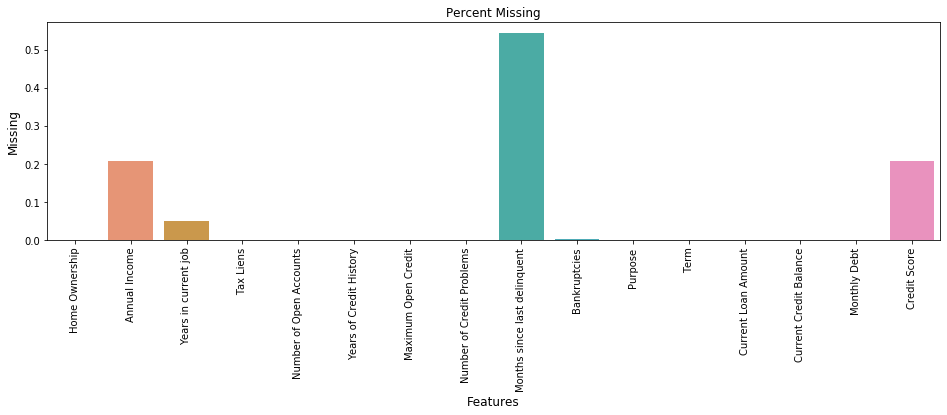

In [17]:
nan_analize(X)

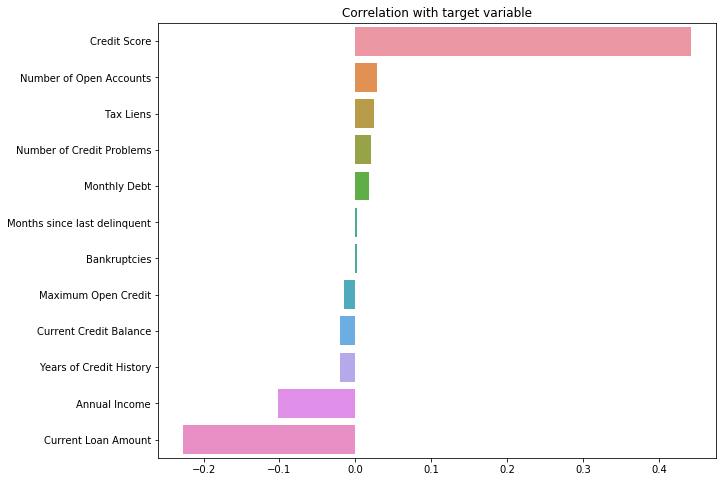

In [31]:
corr_with_target = df_train[base_features + target_name].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

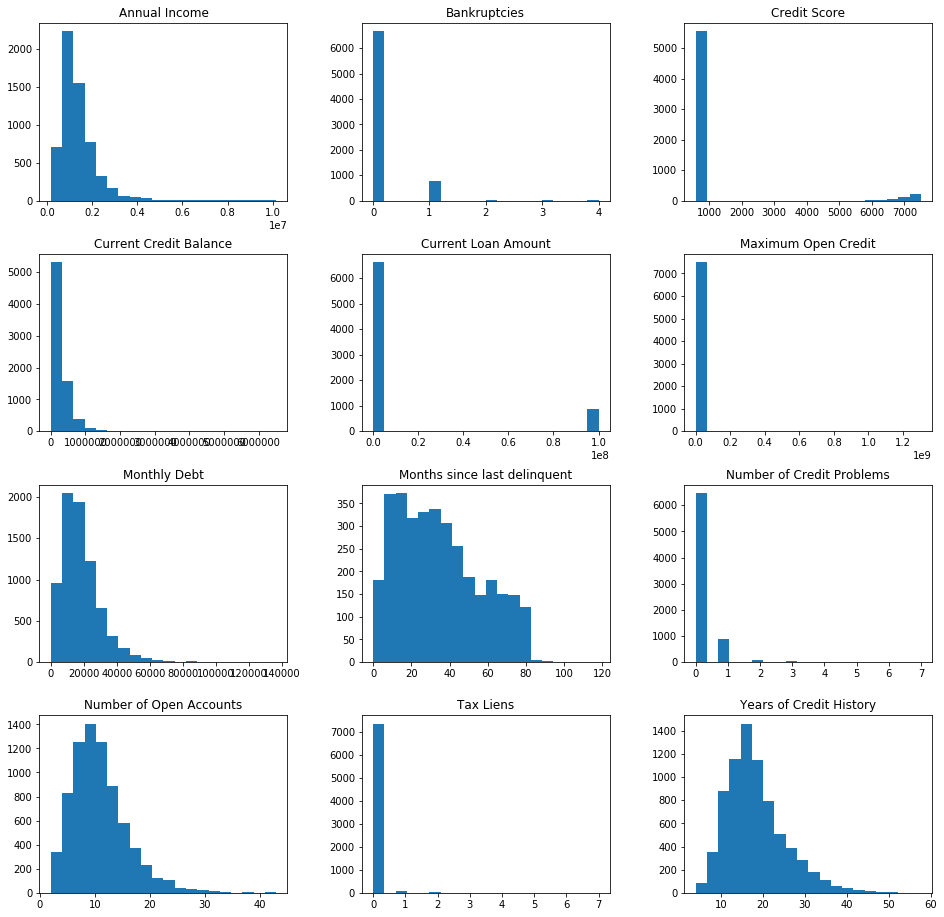

In [32]:
X.hist(figsize=(16,16), bins=20, grid=False);

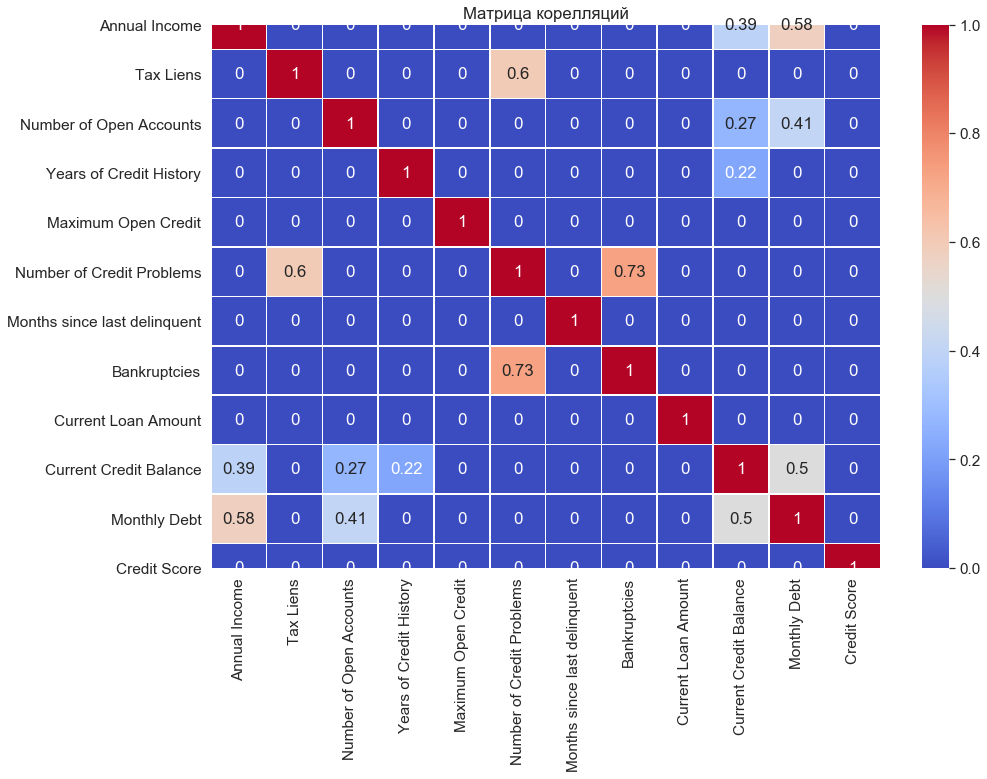

In [54]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0 

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корелляций')
plt.show()

**Изучим распределения переменных в тестовом и тренировочном наборе данных**

Сравнив распределения мы можем выявить целый набор проблем:

1) Home Ownership - в тестовых примерах есть Rent, хотя в тренировочной выборки его нет вовсе
2) Years in current job - перекосы в значениях "4 года" и "10+ лет", причём в разных случаях перекосы в разную сторону.
3) 

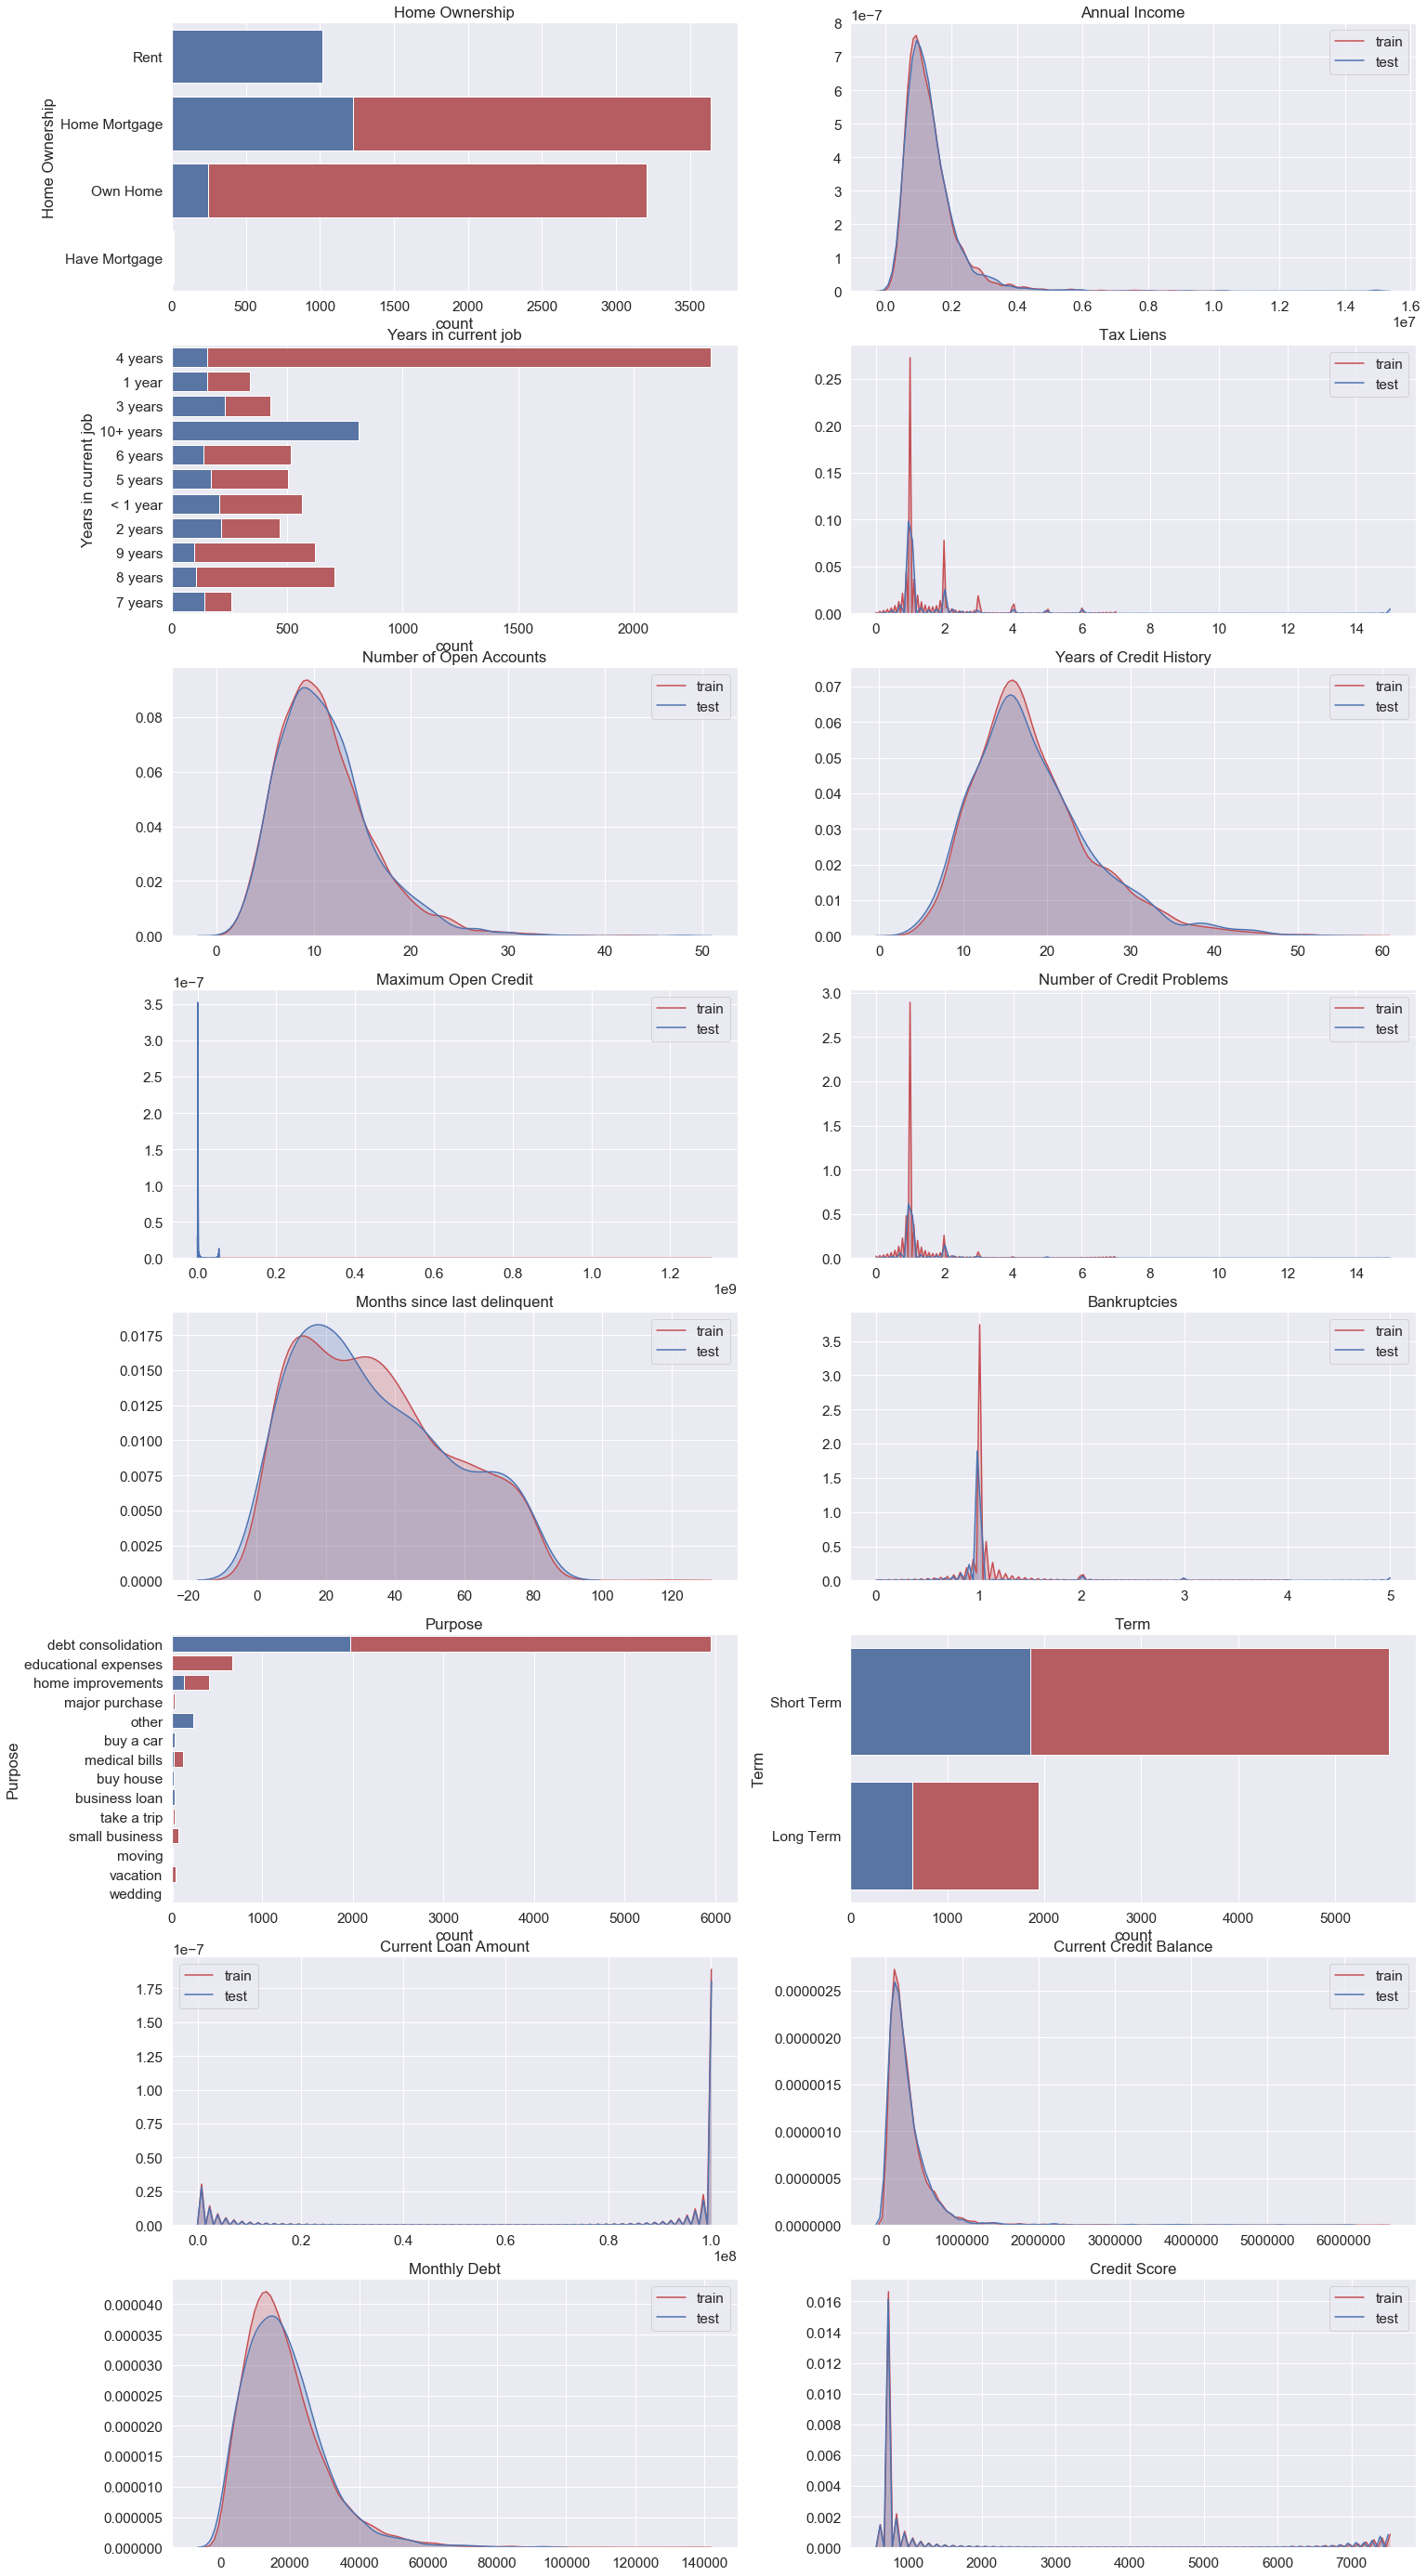

In [101]:
plt.figure(figsize = (24, 50))

l = len(base_features)

for i in range(l):
    plt.subplot((l+1)//2,2,i+1)
    plt.title(base_features[i])
    if X[base_features[i]].dtype == 'float64':
        sns.kdeplot(X[base_features[i]], shade=True, label='train', color='r')
        sns.kdeplot(df_test[base_features[i]], shade=True, label='test', color='b')
    else:
        sns.countplot(y=base_features[i], data=X, color = 'r')
        sns.countplot(y=base_features[i], data=df_test, color = 'b')

plt.show()
#for i in range(0, 5):
#  plt.subplot(5,2,i+1)

**Готовим класс для обработки выбросов**

In [290]:
class Model:
    def __init__(self):
        self.medians = None
        self.scaler = None
        
    def fit(self, X):
        #на тестовых данных будут использоваться медианы из тренировочной выборки
        if self.medians is None:
            self.medians = {}
            for colname in X.columns:
                self.medians[colname] = X[colname].mode()[0]
        print(self.medians)
        
    def scale(self, X):
        
        X_norm = X.copy()
        num_f= ['Annual Income', 'Tax Liens',
           'Number of Open Accounts', 'Years of Credit History',
           'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
            'Current Loan Amount', 'Current Credit Balance',
           'Monthly Debt', 'Credit Score']
        
        if self.scaler is None: 
            scaler = StandardScaler()

            X_norm[num_f] = scaler.fit_transform(X_norm[num_f])
            
            self.scaler = scaler
        else:
            X_norm[num_f] = self.scaler.transform(X_norm[num_f])
            
        return X_norm    
    
    def nan_correction(self, X):
        
        X = X.copy()
        
        #избавляемся от ненужного признака
        
        if 'Months since last delinquent' in X.columns:
            X = X.drop(columns=['Months since last delinquent'])
        
        #устранияем пропуски через медиану
        if self.medians is not None:
            for colname in X.columns:
                X[f'{colname}_nan'] = X[colname].isna() * 1
                X.loc[X[f'{colname}_nan']==1, colname] = self.medians[colname]
                if X[f'{colname}_nan'].sum() == 0:
                    X.drop(f'{colname}_nan', axis=1, inplace=True)
        
        return X
    
    def outliners_fix(self, X):
        
        X = X.copy()
        
        X['Maximum Open Credit'] = winsorize(X['Maximum Open Credit'], limits = 0.15)
        
        return X
    
    def new_features(self, X):
        
        X = X.copy()
        
        # X.select_dtypes(include='object').columns[1:]
        
        for cat_colname in ['Term']:
            X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)
            
        return X

In [291]:
m = Model()

In [292]:
m.fit(X)

{'Home Ownership': 'Home Mortgage', 'Annual Income': 969475.0, 'Years in current job': '10+ years', 'Tax Liens': 0.0, 'Number of Open Accounts': 9.0, 'Years of Credit History': 15.0, 'Maximum Open Credit': 0.0, 'Number of Credit Problems': 0.0, 'Months since last delinquent': 14.0, 'Bankruptcies': 0.0, 'Purpose': 'debt consolidation', 'Term': 'Short Term', 'Current Loan Amount': 99999999.0, 'Current Credit Balance': 0.0, 'Monthly Debt': 0.0, 'Credit Score': 740.0}


In [293]:
res = m.nan_correction(X)

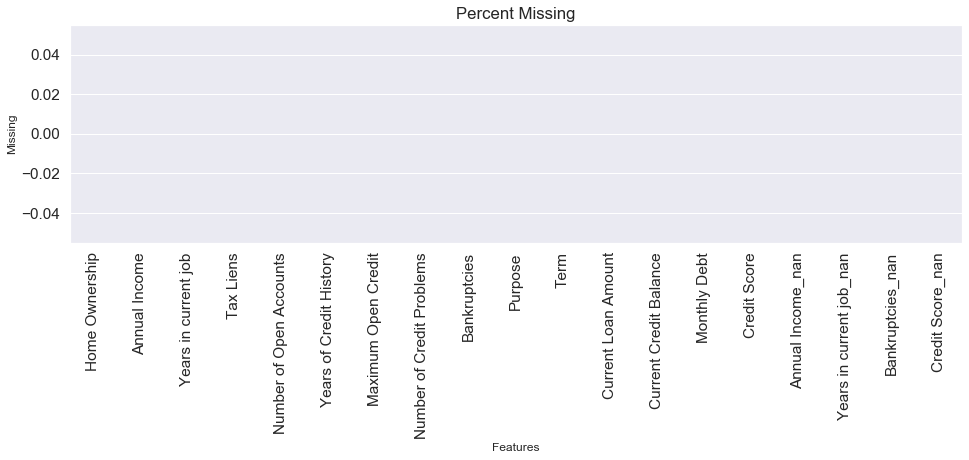

In [294]:
nan_analize(res)

In [295]:
res = m.outliners_fix(res)

In [296]:
res = m.new_features(res)

In [297]:
res = m.scale(res)

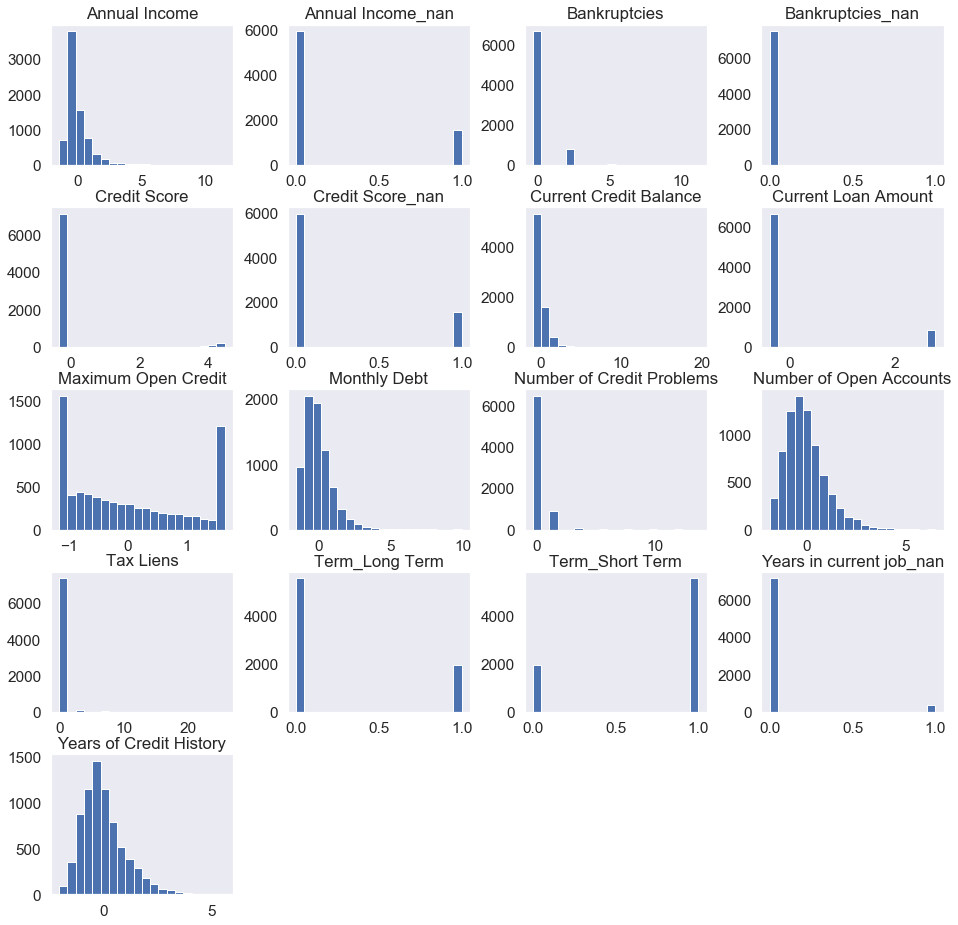

In [108]:
res.hist(figsize=(16,16), bins=20, grid=False);

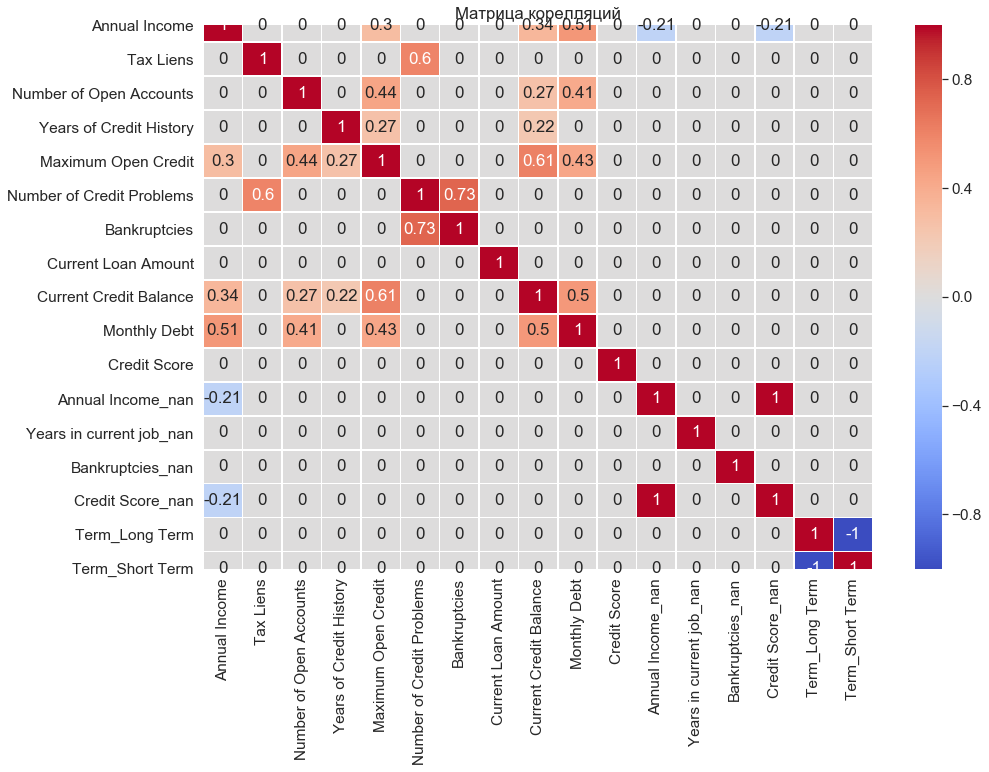

In [109]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = res.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0 

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корелляций')
plt.show()


In [198]:
res.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Annual Income_nan',
       'Years in current job_nan', 'Bankruptcies_nan', 'Credit Score_nan',
       'Term_Long Term', 'Term_Short Term'],
      dtype='object')

In [298]:
number_features = ['Annual Income', 'Annual Income_nan', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
        'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score',
       'Years in current job_nan', 'Bankruptcies_nan', 'Credit Score_nan']


In [299]:
additional_features = ['Term_Long Term', 'Term_Short Term']

In [300]:
cat_features = []
for cat_colname in X.select_dtypes(include='object').columns:
    cat_features.append(cat_colname)
    
cat_features

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [301]:
for colname in cat_features:
    res[colname] = pd.Categorical(res[colname])
    
res[cat_features].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

**Сравним различные модели**

In [302]:
X_train, X_test, y_train, y_test = train_test_split(res, y, shuffle=True, test_size=0.30)

Балансировка

In [303]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
print(df_balanced[target_name].value_counts())

X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


0    3776
1    2948
Name: Credit Default, dtype: int64


In [304]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [206]:
train.to_csv("./current_train.csv", index=False, encoding='utf-8')
test.to_csv("./current_test.csv", index=False, encoding='utf-8')

In [305]:
model_lr = LogisticRegression()
model_lr.fit(X_train[number_features + additional_features], y_train)

y_train_pred = model_lr.predict(X_train[number_features + additional_features])
y_test_pred = model_lr.predict(X_test[number_features + additional_features])

print(y_train_pred.shape, y_test_pred.shape, y_test.shape, y_train.shape)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(6724,) (2250,) (2250,) (6724,)
TRAIN

              precision    recall  f1-score   support

           0       0.69      0.84      0.76      3776
           1       0.72      0.52      0.60      2948

    accuracy                           0.70      6724
   macro avg       0.70      0.68      0.68      6724
weighted avg       0.70      0.70      0.69      6724

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1611
           1       0.55      0.50      0.52       639

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1354  257
1                322  317


In [208]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train[number_features + additional_features], y_train)

y_train_pred = model_knn.predict(X_train[number_features + additional_features])
y_test_pred = model_knn.predict(X_test[number_features + additional_features])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      3771
           1       0.80      0.73      0.77      2958

    accuracy                           0.80      6729
   macro avg       0.80      0.79      0.80      6729
weighted avg       0.80      0.80      0.80      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1616
           1       0.43      0.46      0.44       634

    accuracy                           0.67      2250
   macro avg       0.60      0.61      0.61      2250
weighted avg       0.68      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1223  393
1                342  292


In [209]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train[number_features + additional_features], y_train)

y_train_pred = model_xgb.predict(X_train[number_features + additional_features])
y_test_pred = model_xgb.predict(X_test[number_features + additional_features])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3771
           1       0.98      0.96      0.97      2958

    accuracy                           0.98      6729
   macro avg       0.98      0.97      0.97      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1616
           1       0.51      0.45      0.48       634

    accuracy                           0.72      2250
   macro avg       0.65      0.64      0.65      2250
weighted avg       0.71      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1343  273
1                348  286


In [210]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train[number_features + additional_features], y_train)

y_train_pred = model_lgbm.predict(X_train[number_features + additional_features])
y_test_pred = model_lgbm.predict(X_test[number_features + additional_features])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3771
           1       0.94      0.87      0.90      2958

    accuracy                           0.92      6729
   macro avg       0.92      0.91      0.92      6729
weighted avg       0.92      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1616
           1       0.50      0.47      0.49       634

    accuracy                           0.72      2250
   macro avg       0.65      0.64      0.65      2250
weighted avg       0.71      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1321  295
1                336  298


In [211]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, cat_features=cat_features)
model_catb.fit(X_train[number_features + cat_features], y_train)

y_train_pred = model_catb.predict(X_train[number_features + cat_features])
y_test_pred = model_catb.predict(X_test[number_features + cat_features])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3771
           1       0.90      0.82      0.86      2958

    accuracy                           0.88      6729
   macro avg       0.89      0.88      0.88      6729
weighted avg       0.88      0.88      0.88      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1616
           1       0.53      0.49      0.51       634

    accuracy                           0.73      2250
   macro avg       0.67      0.66      0.66      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1341  275
1                324  310


In [212]:
c_dataset = Pool(data=pd.concat([X_train, X_test], ignore_index=True),
                  label=pd.concat([y_train, y_test], ignore_index=True),
                  cat_features=cat_features)


params = {"iterations": 220,
          
          "max_depth":5,
          "eval_metric":"F1",
          "l2_leaf_reg":10.0,
          "loss_function": "Logloss",
          "colsample_bylevel":0.5,
          "verbose": False}
scores = cv(c_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [232]:
c_dataset = Pool(data=pd.concat([X_train, X_test], ignore_index=True),
                  label=pd.concat([y_train, y_test], ignore_index=True),
                  cat_features=cat_features)


params = {"iterations": 220,
          
          "max_depth":3,
          "eval_metric":"F1",
          "l2_leaf_reg":10.0,
          "loss_function": "Logloss",
          "colsample_bylevel":0.5,
          "verbose": False}
scores = cv(c_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

**Финальая модель**

In [306]:
model_catb_f = catb.CatBoostClassifier(silent=True, cat_features=cat_features, iterations = 219, eval_metric="F1", loss_function="Logloss", colsample_bylevel=0.5, max_depth=3)
model_catb_f.fit(X_train[number_features + cat_features], y_train)

y_train_pred = model_catb_f.predict(X_train[number_features + cat_features])
y_test_pred = model_catb_f.predict(X_test[number_features + cat_features])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.86      0.79      3776
           1       0.77      0.61      0.68      2948

    accuracy                           0.75      6724
   macro avg       0.75      0.73      0.74      6724
weighted avg       0.75      0.75      0.74      6724

TEST

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1611
           1       0.56      0.54      0.55       639

    accuracy                           0.75      2250
   macro avg       0.69      0.69      0.69      2250
weighted avg       0.75      0.75      0.75      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1346  265
1                297  342


In [307]:
y_test_pred_probs = model_catb_f.predict_proba(X_test[number_features + cat_features])

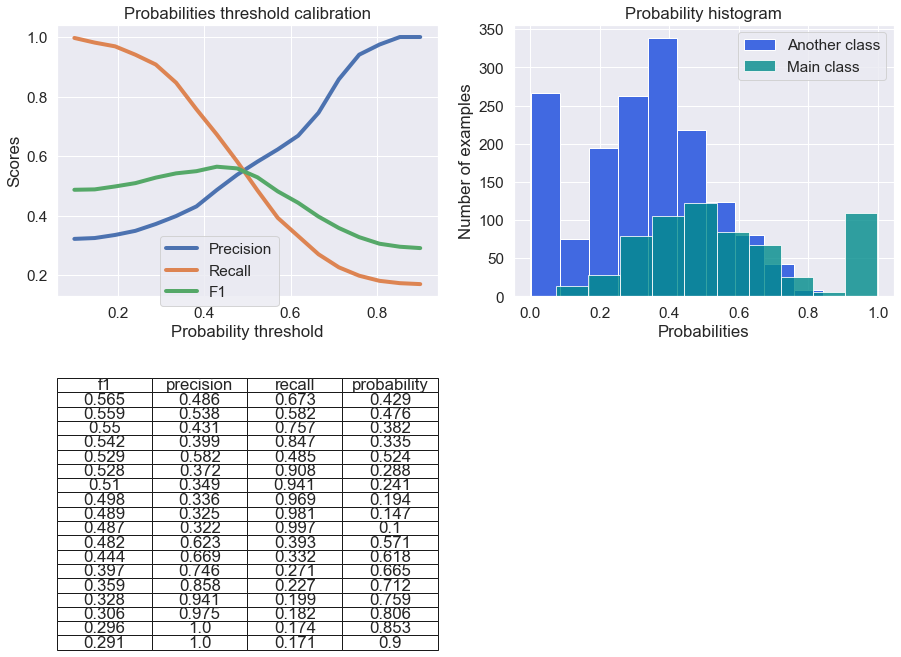

In [308]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [309]:
threshold_prob = 0.429

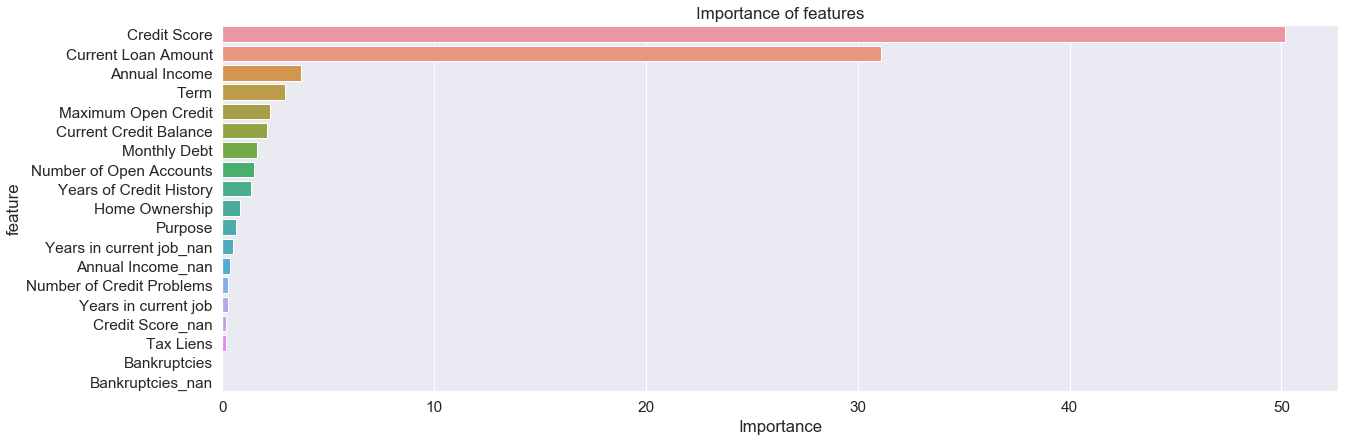

In [239]:
important_features_top = show_feature_importances(X_train[number_features + cat_features].columns, model_catb_f.feature_importances_, get_top=15)

In [310]:
y_pred = np.array([1 if x>=threshold_prob else 0 for x in y_test_pred_probs[:,1]])

In [311]:
get_classification_report(y_train, y_train_pred, y_test, y_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.86      0.79      3776
           1       0.77      0.61      0.68      2948

    accuracy                           0.75      6724
   macro avg       0.75      0.73      0.74      6724
weighted avg       0.75      0.75      0.74      6724

TEST

              precision    recall  f1-score   support

           0       0.85      0.72      0.78      1611
           1       0.49      0.68      0.57       639

    accuracy                           0.71      2250
   macro avg       0.67      0.70      0.67      2250
weighted avg       0.75      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1156  455
1                207  432


In [312]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(model_catb_f, file)

## Тестовая выборка

In [313]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [318]:
df_test.shape

(2500, 16)

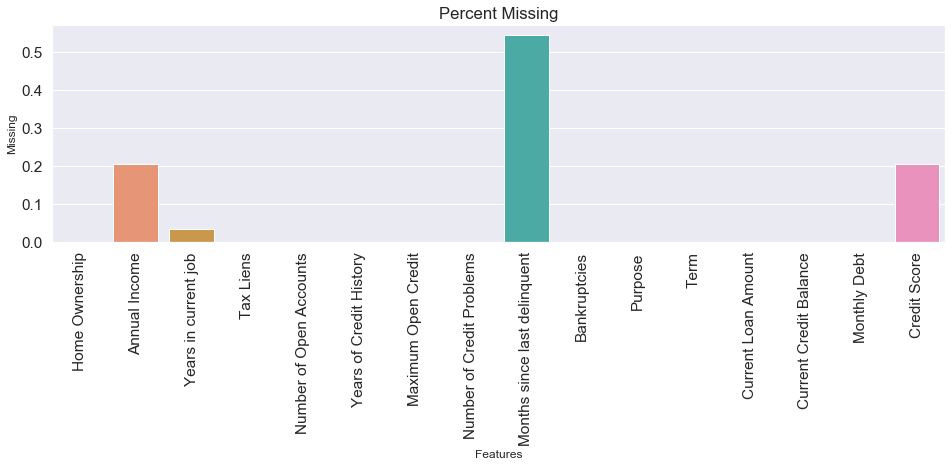

In [316]:
nan_analize(df_test)

In [317]:
df_test_mod = m.nan_correction(df_test)

In [319]:
df_test_mod = m.outliners_fix(df_test_mod)

In [320]:
df_test_mod = m.scale(df_test_mod)

In [263]:
df_test_mod.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Annual Income_nan,Years in current job_nan,Bankruptcies_nan,Credit Score_nan
0,Rent,-0.408750,4 years,-0.110953,-0.434123,-0.826171,-1.114780,-0.340979,-0.337099,debt consolidation,Short Term,-0.366831,-0.578660,-0.964404,-0.226557,1,0,0,1
1,Rent,-1.367393,1 year,-0.110953,-1.045295,2.042545,-1.166292,-0.340979,-0.337099,educational expenses,Short Term,-0.369468,-0.767016,-1.341313,-0.255072,0,0,0,0
2,Home Mortgage,-0.170836,3 years,-0.110953,-0.230398,-0.655753,-1.166292,-0.340979,-0.337099,debt consolidation,Short Term,-0.365650,-0.450977,0.034760,4.308111,0,0,0,0
3,Home Mortgage,-0.082758,10+ years,-0.110953,0.991947,-0.187101,-0.312708,-0.340979,-0.337099,debt consolidation,Short Term,-0.365111,-0.241102,0.775161,-0.227252,0,0,0,0
4,Home Mortgage,1.373639,6 years,-0.110953,-0.026674,0.750203,1.719652,-0.340979,-0.337099,debt consolidation,Long Term,-0.347561,0.426483,2.036777,-0.250204,0,0,0,0


In [321]:
df_test_mod.shape

(2500, 19)

In [322]:
X_train_final = pd.concat([X_train, X_test])
y_train_final = pd.concat([y_train, y_test])

In [323]:
model_catb_f_test = catb.CatBoostClassifier(silent=True, cat_features=cat_features, iterations = 219, eval_metric="F1", loss_function="Logloss", colsample_bylevel=0.5, max_depth=3)
model_catb_f_test.fit(X_train_final[number_features + cat_features], y_train_final)

In [324]:
y_test_f_pred_probs = model_catb_f.predict_proba(df_test_mod[number_features + cat_features])

In [337]:
y_test_f_pred_probs[:,1].shape

(2500,)

In [334]:
y_test_f_pred_probs[0,:]

array([0.52475778, 0.47524222])

In [340]:
y_pred_f = np.array([1 if x>=threshold_prob else 0 for x in y_test_f_pred_probs[:,1]])

In [341]:
y_pred_f.shape

(2500,)

In [342]:
y_pred_df = pd.DataFrame(y_pred_f, columns=[target_name])

In [343]:
y_pred_df.shape

(2500, 1)

In [344]:
import csv
filename = '201104 Egorov.csv'
y_pred_df.to_csv(filename, index=None)